# Credit Risk Analysis
## by Tom Esch

## Preliminary Wrangling

> Here is the Prosper Loan Data, a personal loans company. 

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline
plt.style.use('classic')

> I would like to see what variables affect a loan not being repaid in order to descrease the chance of lending to risky borrowers. The question is which borrowers are the most risk?

In [2]:
df = pd.read_csv('prosperLoanData.csv')

In [3]:
print(df.shape)
df.info()

(113937, 81)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 113937 entries, 0 to 113936
Data columns (total 81 columns):
 #   Column                               Non-Null Count   Dtype  
---  ------                               --------------   -----  
 0   ListingKey                           113937 non-null  object 
 1   ListingNumber                        113937 non-null  int64  
 2   ListingCreationDate                  113937 non-null  object 
 3   CreditGrade                          28953 non-null   object 
 4   Term                                 113937 non-null  int64  
 5   LoanStatus                           113937 non-null  object 
 6   ClosedDate                           55089 non-null   object 
 7   BorrowerAPR                          113912 non-null  float64
 8   BorrowerRate                         113937 non-null  float64
 9   LenderYield                          113937 non-null  float64
 10  EstimatedEffectiveYield              84853 non-null   float64
 11  

In [4]:
df.dtypes.value_counts()

float64    50
object     17
int64      11
bool        3
dtype: int64

In [5]:
# create a new dataframe with loan statuses that have not been repaid
df_default = df.query("LoanStatus == 'Defaulted' or LoanStatus == 'Chargedoff'")
df_clean = df_default[['LoanStatus', 'BorrowerAPR', 'ProsperScore', 'IsBorrowerHomeowner', 'IncomeRange', 'StatedMonthlyIncome', 'IncomeVerifiable', 'LoanOriginalAmount', 'DebtToIncomeRatio', 'CurrentDelinquencies', 'Occupation']].copy()

In [6]:
df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 17010 entries, 15 to 113926
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   LoanStatus            17010 non-null  object 
 1   BorrowerAPR           17010 non-null  float64
 2   ProsperScore          6341 non-null   float64
 3   IsBorrowerHomeowner   17010 non-null  bool   
 4   IncomeRange           17010 non-null  object 
 5   StatedMonthlyIncome   17010 non-null  float64
 6   IncomeVerifiable      17010 non-null  bool   
 7   LoanOriginalAmount    17010 non-null  int64  
 8   DebtToIncomeRatio     15514 non-null  float64
 9   CurrentDelinquencies  16777 non-null  float64
 10  Occupation            16197 non-null  object 
dtypes: bool(2), float64(5), int64(1), object(3)
memory usage: 1.3+ MB


In [7]:
df_clean.isna().sum()

LoanStatus                  0
BorrowerAPR                 0
ProsperScore            10669
IsBorrowerHomeowner         0
IncomeRange                 0
StatedMonthlyIncome         0
IncomeVerifiable            0
LoanOriginalAmount          0
DebtToIncomeRatio        1496
CurrentDelinquencies      233
Occupation                813
dtype: int64

In [8]:
# drop null values from this dataset
df_clean.dropna(inplace=True)
df_clean.isna().sum()

LoanStatus              0
BorrowerAPR             0
ProsperScore            0
IsBorrowerHomeowner     0
IncomeRange             0
StatedMonthlyIncome     0
IncomeVerifiable        0
LoanOriginalAmount      0
DebtToIncomeRatio       0
CurrentDelinquencies    0
Occupation              0
dtype: int64

In [9]:
df_clean.duplicated().sum()

0

### What is the structure of your dataset?

> The original dataset has 81 variables and 113937 observations. This includes 50 float64, 17 object, 11 int64, and 3 boolean datatypes. 

### What is/are the main feature(s) of interest in your dataset?

> Main features of interest are unpaid loans and the variables that affect LoanStatus as being either Defaulted or Chargedoff. 

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> Many variables can affect this. Specifically, we will look at 'ProsperScore', 'IsBorrowerHomeowner', 'IncomeRange', 'StatedMonthlyIncome', 'IncomeVerifiable', 'LoanOriginalAmount', 'DebtToIncomeRatio', 'CurrentDelinquencies', and 'Occupation'

## Univariate Exploration

Text(0.5, 0, 'Number of Unpaid Loans')

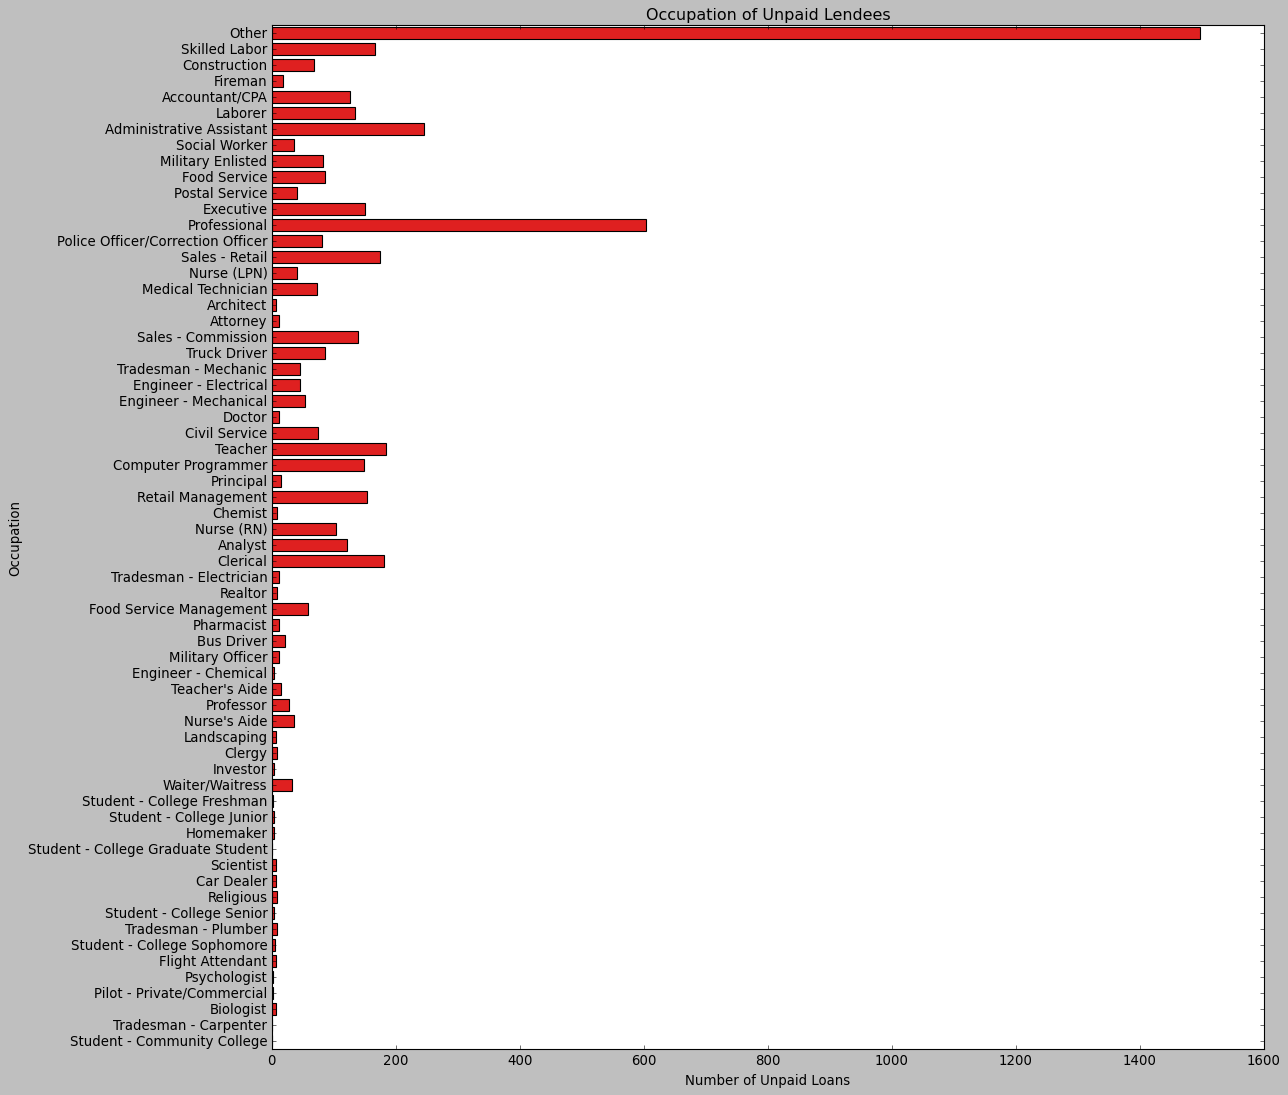

In [10]:
color = sns.color_palette()[2]
plt.figure(figsize=(16,16))
chart1 = sns.countplot(data=df_clean, y='Occupation', color=color)
plt.title('Occupation of Unpaid Lendees')
plt.xlabel('Number of Unpaid Loans')

> It looks like "other" and "professional" occupations are the biggest borrowers. From the figure above, we can only know what these occupations are *not*, since these aren't describe well.  

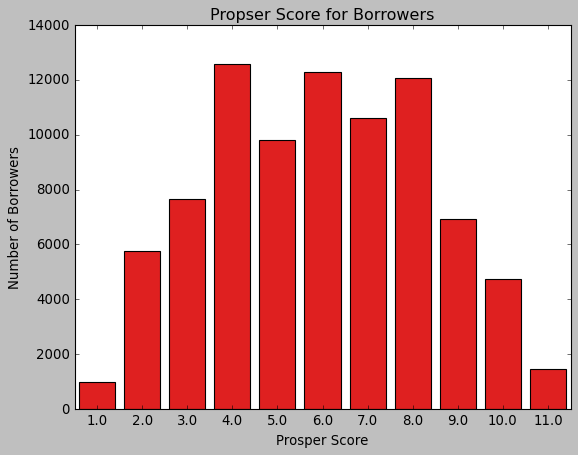

In [11]:
# Let's look at ProsperScore for borrowers
sns.countplot(data = df, x = 'ProsperScore', color = color);
plt.xticks(rotation = 0)
plt.title('Propser Score for Borrowers')
plt.xlabel('Prosper Score')
plt.ylabel('Number of Borrowers');

> Most of the borrowers have a ProsperScore in the 4.0 to 8.0 range, which makes sense from the lender's perspective. However, since these are unpaid loans we are analyzing, it doesn't give us much information as to whether or not a borrower will default. 

In [12]:
# Let's only look at borrowers whose income can be verified
df_clean = df_clean.query('IncomeVerifiable == True').copy()
df_clean.drop(columns='IncomeVerifiable', inplace=True)
df_clean.shape

(5330, 10)

Text(0.5, 0, 'Monthly Income')

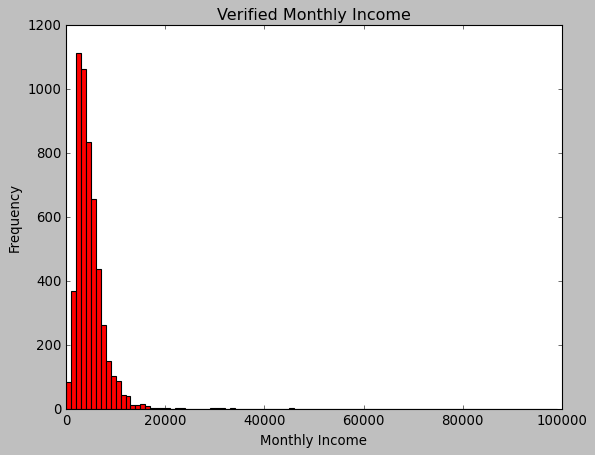

In [13]:
bins = np.arange(0,100000, 1000)
plt.title('Verified Monthly Income')
plt.hist(data=df_clean, x='StatedMonthlyIncome', bins=bins,color=color);
plt.ylabel('Frequency')
plt.xlabel('Monthly Income')

> Histogram is right-skewed. Let's try a log transform to get a better idea of the distribution of monthly income

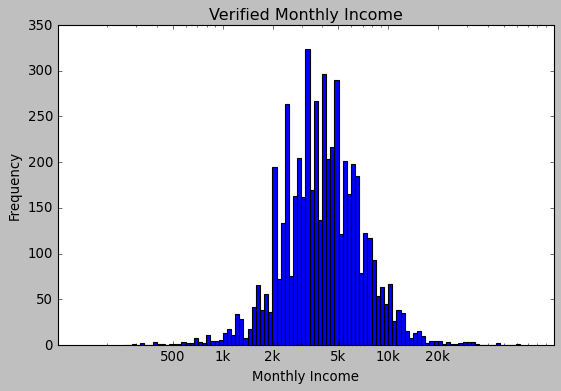

In [14]:
log_binsize = 0.025
bins = 10 ** np.arange(2.4, np.log10(df_clean.StatedMonthlyIncome.max())+log_binsize, log_binsize)
plt.figure(figsize=[8, 5])
plt.title('Verified Monthly Income')
plt.hist(data = df_clean, x = 'StatedMonthlyIncome', bins = bins)
plt.xscale('log')
plt.xticks([500, 1e3, 2e3, 5e3, 1e4, 2e4], [500, '1k', '2k', '5k', '10k', '20k'])
plt.xlabel('Monthly Income')
plt.ylabel('Frequency')
plt.show()

> Most monthly incomes fall in the 1k-10k range. 

> Let's look at the homeowner status of default borrowers

<ipython-input-15-6abcb26818d5>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_unpaid = df_clean[(df.LoanStatus == 'Defaulted') | (df.LoanStatus == 'Chargedoff')]


Text(0.5, 0, 'IsBorrowerHomeowner')

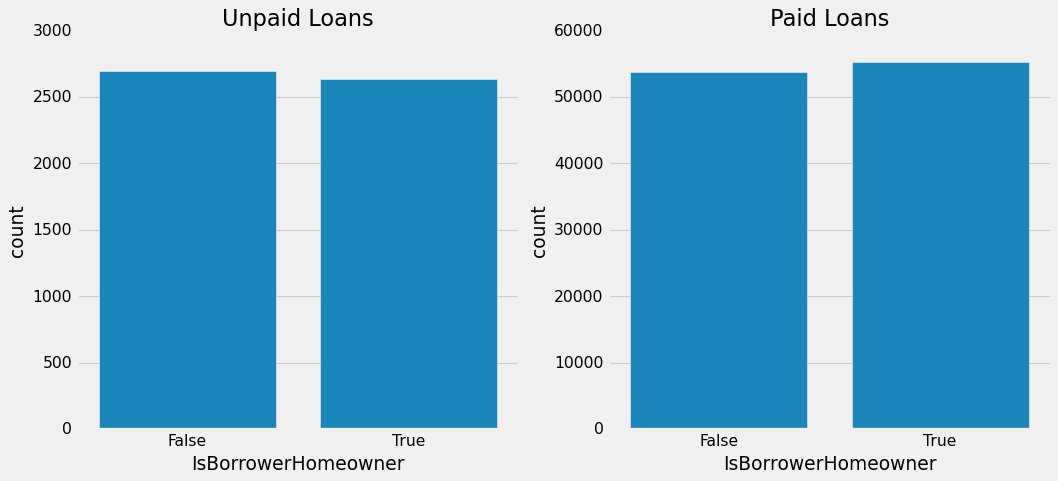

In [15]:
plt.style.use('fivethirtyeight')
color = sns.color_palette()[0]
df_unpaid = df_clean[(df.LoanStatus == 'Defaulted') | (df.LoanStatus == 'Chargedoff')]
df_paid = df[df.LoanStatus != 'Defaulted']

plt.figure(figsize=[14,6])

# Use subplots to display data
plt.subplot(1,2,1)
sns.countplot(data=df_unpaid, x='IsBorrowerHomeowner', color=color)
plt.title('Unpaid Loans')
plt.xlabel('IsBorrowerHomeowner')

plt.subplot(1,2,2)
sns.countplot(data=df_paid, x='IsBorrowerHomeowner', color=color)
plt.title('Paid Loans')
plt.xlabel('IsBorrowerHomeowner')

> Looks like homeownership does not have an affect on loan repayment.

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> Monthly income had a long right tail so we performed a log transform to get a better idea of the distribution. Occupation type tells us that "other" and "professional" occupations are most likely to default as they have the highest number of defaults. Looking at whether or not the borrower is a homeowner we can see that this variable does not affect loan repayment.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I dropped values with missing observations. There were no duplicates. For this analysis, the data is clean and tidy. Also, before looking at the StatedMonthlyIncome, I dropped the observations where the income was not verified. 

## Bivariate Exploration

>  Let's now look at differences of those who defaulted and those who paid. 

In [16]:
df_b = df[['LoanStatus', 'EmploymentStatus', 'BorrowerAPR', 'ProsperScore', 'IsBorrowerHomeowner', 'IncomeRange', 'StatedMonthlyIncome', 'IncomeVerifiable', 'LoanOriginalAmount', 'DebtToIncomeRatio', 'CurrentDelinquencies', 'TotalCreditLinespast7years', 'Occupation']].copy()
df_b.dropna(inplace=True)
df_b.isna().sum()

LoanStatus                    0
EmploymentStatus              0
BorrowerAPR                   0
ProsperScore                  0
IsBorrowerHomeowner           0
IncomeRange                   0
StatedMonthlyIncome           0
IncomeVerifiable              0
LoanOriginalAmount            0
DebtToIncomeRatio             0
CurrentDelinquencies          0
TotalCreditLinespast7years    0
Occupation                    0
dtype: int64

In [17]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 76224 entries, 1 to 113936
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   LoanStatus                  76224 non-null  object 
 1   EmploymentStatus            76224 non-null  object 
 2   BorrowerAPR                 76224 non-null  float64
 3   ProsperScore                76224 non-null  float64
 4   IsBorrowerHomeowner         76224 non-null  bool   
 5   IncomeRange                 76224 non-null  object 
 6   StatedMonthlyIncome         76224 non-null  float64
 7   IncomeVerifiable            76224 non-null  bool   
 8   LoanOriginalAmount          76224 non-null  int64  
 9   DebtToIncomeRatio           76224 non-null  float64
 10  CurrentDelinquencies        76224 non-null  float64
 11  TotalCreditLinespast7years  76224 non-null  float64
 12  Occupation                  76224 non-null  object 
dtypes: bool(2), float64(6), int64(

> Let's see if there is any notable correlation in our numeric variables

In [18]:
num_vars = ['BorrowerAPR', 'ProsperScore', 'StatedMonthlyIncome', 'DebtToIncomeRatio', 'CurrentDelinquencies', 'TotalCreditLinespast7years']

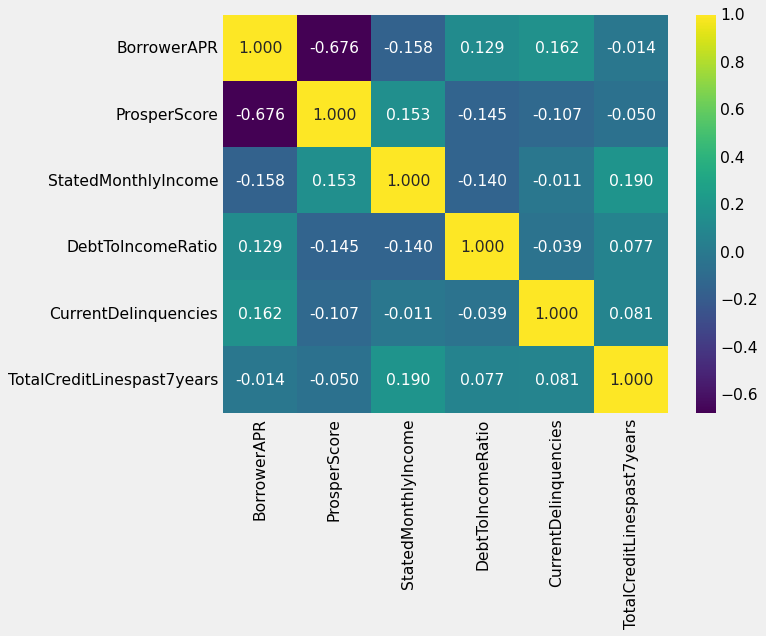

In [19]:
sns.heatmap(df_b[num_vars].corr(), cmap='viridis', annot=True, fmt='0.3f' )

> The strongest correlation here is a negative correlation between ProsperScore and BorrowerAPR, which makes sense the borrower would have a higher APR with a lower ProsperScore. 

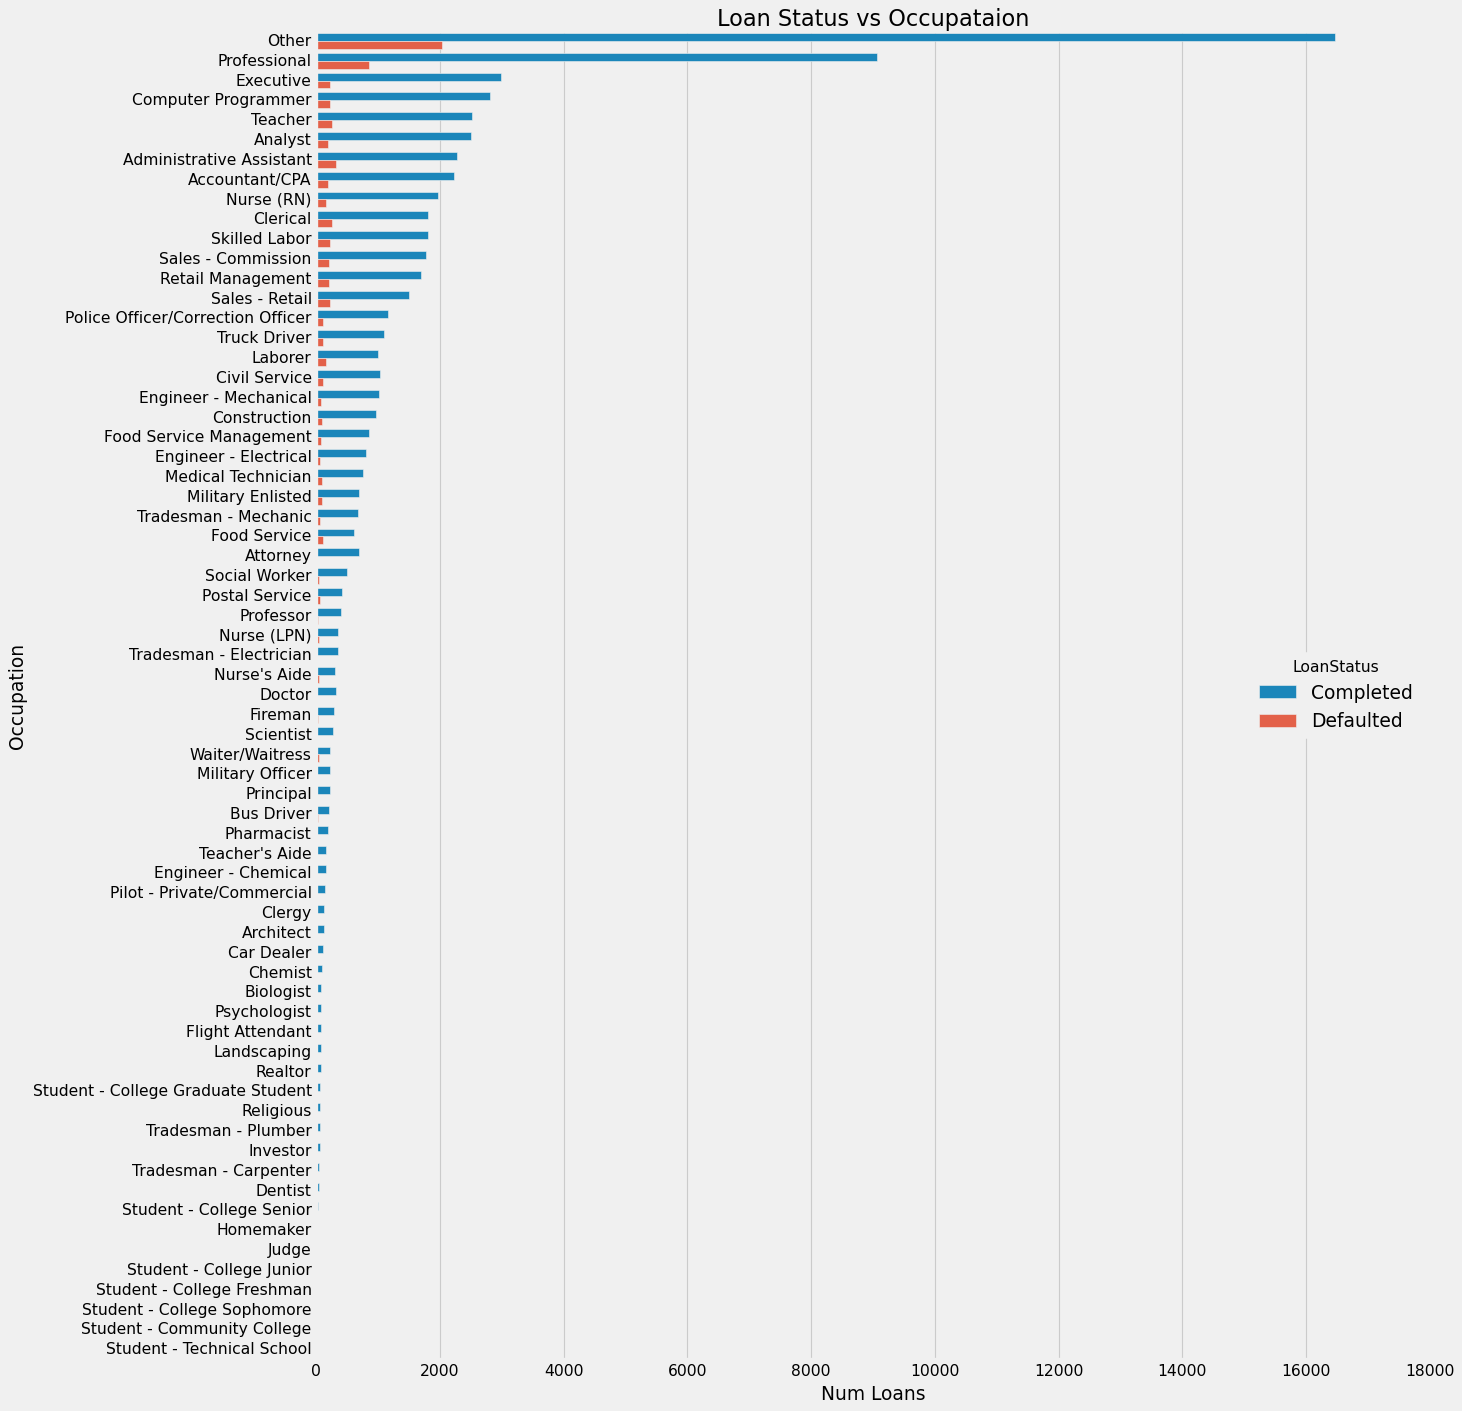

In [20]:
# Group loan status into 2 categories
df_b['LoanStatus'] = np.where((df_b['LoanStatus'] == 'Current') | (df_b['LoanStatus'] == 'Completed')| 
                         (df_b['LoanStatus'] == 'Cancelled'), 
                         'Completed', 'Defaulted')
order = df_b['Occupation'].value_counts().index
plt.figure(figsize=(16,20))
sns.countplot(data = df_b, y = 'Occupation', hue='LoanStatus', order=order);
plt.xlabel('Num Loans')
plt.ylabel('Occupation')
plt.title('Loan Status vs Occupataion');

> Occupation types look similar for defaults and completed loans. 

> Let's look at loan status and income range. 

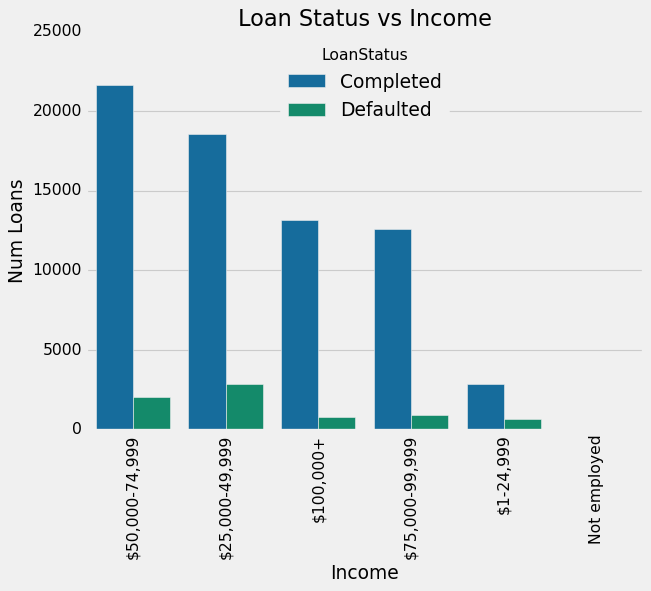

In [21]:
plt.style.use('seaborn-colorblind')
sns.countplot(data = df_b, x='IncomeRange', hue='LoanStatus');
plt.xlabel('Income')
plt.ylabel('Num Loans')
plt.title('Loan Status vs Income');
plt.xticks(rotation = 90);

> Income Range with most defaults is the 25k - 49.9k, and has the second highest completed payments. Those in this income group may be more risky to lend to. 

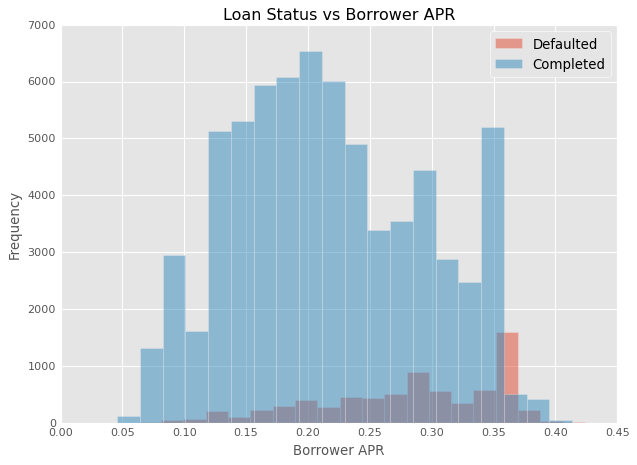

In [22]:
plt.style.use('ggplot')
defaulted = df_b['LoanStatus'] == 'Defaulted'
completed = df_b['LoanStatus'] == 'Completed'
df_b['BorrowerAPR'][defaulted].hist(label = 'Defaulted', alpha = 0.5, bins = 20)
df_b['BorrowerAPR'][completed].hist(label = 'Completed', alpha = 0.5, bins = 20)
plt.xlabel('Borrower APR')
plt.ylabel('Frequency')
plt.title('Loan Status vs Borrower APR');
plt.legend();



> Interesting to see that the BorrowerAPR of around 0.35 has both the highest number of defaults and number of completed loans also spikes at this APR. 

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> Income range is an interesting variable as we see the highest amount of default loans in the 25k-49.9k range and only the second highest completed loans. So we may want to be more strict on lending to this group.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> It looks like for the BorrowerAPR of around 0.35 the highest amount defaults. The BorrowerAPR in the range of 0.10-0.37 has the greatest number of defaults, while the BorrowerAPR in the range of 0.07 to 0.37 makes up the majority of completed loans. 

## Multivariate Exploration

> Create plots of three or more variables to investigate your data even
further. Make sure that your investigations are justified, and follow from
your work in the previous sections.

In [23]:
df_m = df[['LoanStatus', 'EmploymentStatus', 'BorrowerAPR', 'ProsperScore', 'IncomeRange', 'StatedMonthlyIncome', 'IncomeVerifiable', 'LoanOriginalAmount', 'DebtToIncomeRatio', 'CurrentDelinquencies']].copy()
# create column with relevant loan statuses
df_m['LoanStatus'] = np.where((df_m['LoanStatus'] == 'Current') | 
                         (df_m['LoanStatus'] == 'Completed')| 
                         (df_m['LoanStatus'] == 'Cancelled'), 
                         'Completed', 'Defaulted')

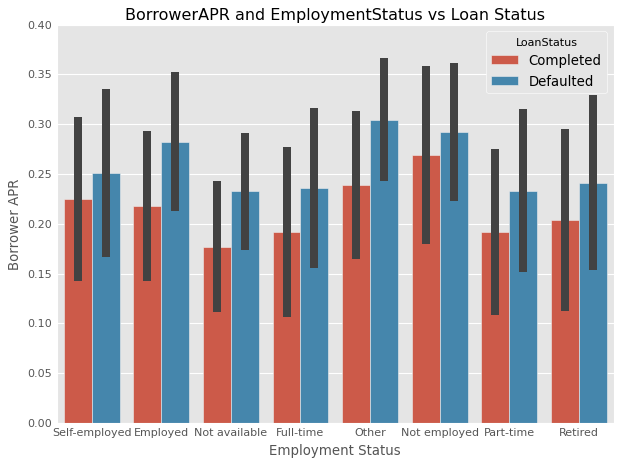

In [24]:
sns.barplot(data=df_m, y = 'BorrowerAPR', 
            x='EmploymentStatus', hue="LoanStatus", ci='sd');

plt.xlabel('Employment Status')
plt.ylabel('Borrower APR')
plt.title('BorrowerAPR and EmploymentStatus vs Loan Status');

> This is interesting to see that for each category of employment status, the BorrowerAPR is higher for the group that defaults on their loan. 

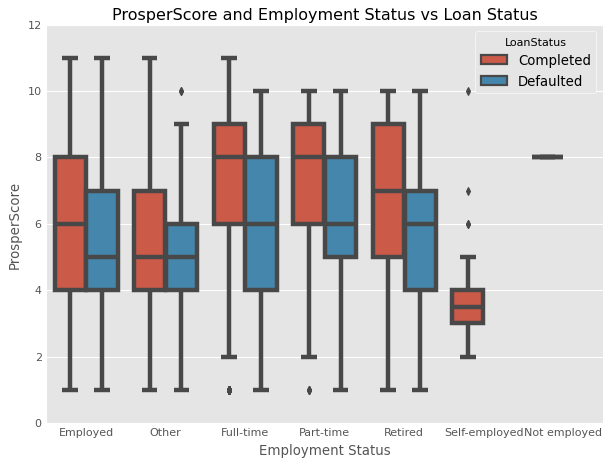

In [25]:
df_m.dropna(inplace=True)
sns.boxplot(data = df_m, y='ProsperScore', 
            x='EmploymentStatus', hue="LoanStatus");

plt.xlabel('Employment Status')
plt.ylabel('ProsperScore')
plt.title('ProsperScore and Employment Status vs Loan Status');

> Interesting to see that self-employed's completed most of their loans yet have a lower ProsperScore than any other group. Most other groups are similar as to whether they default or not based on their ProsperScore, however it is slightly apparent that lower PropserScore is associated with defaults as the IQR is lower in the full-time, part-time, and retired groups.

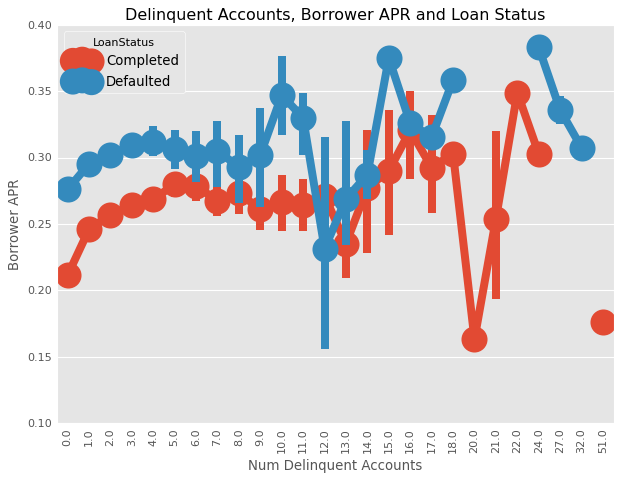

In [26]:
sns.pointplot(data=df_m, x='CurrentDelinquencies', 
            y='BorrowerAPR', hue="LoanStatus");

plt.xlabel('Num Delinquent Accounts')
plt.ylabel('Borrower APR')
plt.title('Delinquent Accounts, Borrower APR and Loan Status');
plt.xticks(rotation=90);

> Borrower APR sees an increasing trend as number of delinquent accounts goes up. This makes sense.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> None of the variables looked at seem to have an effect on whether or not a loan will default other than ProsperScore. 

### Were there any interesting or surprising interactions between features?

> Interestingly, the borrower APR goes up for both groups as the number of delinquent accounts goes up, however the APR drops at 9 delinquent accounts for the default group, and then begins going back up after 13 delinquent accounts. In the group that completed their loans, the APR drops after 18 delinquent accounts, and then goes back up around 20 delinquent accounts. 

> At the end of your report, make sure that you export the notebook as an
html file from the `File > Download as... > HTML` menu. Make sure you keep
track of where the exported file goes, so you can put it in the same folder
as this notebook for project submission. Also, make sure you remove all of
the quote-formatted guide notes like this one before you finish your report!